In [2]:
import sys
sys.path.append('../../../')

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    return None
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = False

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_mcc'
metric_filter_2 = 'test_mcc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.07, 0.03, 0.9)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = dataset.num_classes

In [7]:
(dataset[0].ndata['train_mask']).sum()

tensor(105)

In [8]:
(dataset[0].ndata['val_mask']).sum()

tensor(45)

In [9]:
(dataset[0].ndata['test_mask']).sum()

tensor(1350)

## Baseline

In [10]:
dict_small_acc_train = {}
dict_small_acc_val = {}
dict_small_acc_test = {}
dict_small_rmse_train = {}
dict_small_rmse_val = {}
dict_small_rmse_test = {}
dict_small_mcc_train = {}
dict_small_mcc_val = {}
dict_small_mcc_test = {}

In [11]:
# x_train,x_test,y_train,y_test = train_test_split(dataset.node_features[0].to_numpy(), dataset.targets[0], test_size=0.25, random_state=seed)
g_data = dataset.graphs[0].ndata
feats = g_data['feat']
labels = g_data['label']
train_mask = g_data['train_mask']
val_mask = g_data['val_mask']
test_mask = g_data['test_mask']

# train + val for training, test for test
x_train,x_test = feats[torch.logical_not(test_mask)], feats[test_mask]
y_train,y_test = labels[torch.logical_not(test_mask)], labels[test_mask]

In [12]:
x_train.shape

torch.Size([150, 4])

In [13]:
x_test.shape

torch.Size([1350, 4])

### Logistic Regression

In [14]:
model_lr = LogisticRegression(multi_class='multinomial',random_state=seed, max_iter=800).fit(x_train, y_train)
print(classification_report(y_true=y_test, y_pred=model_lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.77      0.57      0.66       335
           1       0.30      0.34      0.31       334
           2       0.30      0.17      0.22       342
           3       0.48      0.75      0.59       339

    accuracy                           0.46      1350
   macro avg       0.46      0.46      0.44      1350
weighted avg       0.46      0.46      0.44      1350



In [15]:
dict_small_acc_train['logistic_regression'] = model_lr.score(x_train, y_train)
dict_small_acc_test['logistic_regression'] = model_lr.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['logistic_regression']}")
print(f"Test accuracy: {dict_small_acc_test['logistic_regression']}")

dict_small_rmse_train['logistic_regression'] = mean_squared_error(y_true=y_train,y_pred=model_lr.predict(x_train), squared=False)
dict_small_rmse_test['logistic_regression'] = mean_squared_error(y_true=y_test,y_pred=model_lr.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['logistic_regression']}")
print(f"Test rmse: {dict_small_rmse_test['logistic_regression']}")

dict_small_mcc_train['logistic_regression'] = matthews_corrcoef(y_true=y_train,y_pred=model_lr.predict(x_train))
dict_small_mcc_test['logistic_regression'] = matthews_corrcoef(y_true=y_test,y_pred=model_lr.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['logistic_regression']}")
print(f"Test mcc: {dict_small_mcc_test['logistic_regression']}")

Train accuracy: 0.46
Test accuracy: 0.4562962962962963
Train rmse: 1.0424330514074593
Test rmse: 1.023067283548187
Train mcc: 0.2892639292086052
Test mcc: 0.2821549906874376


### Random Forest

In [16]:
# # x_train_rf,x_val_rf,y_train_rf,y_val_rf = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)
# x_train_rf,x_val_rf,x_test_rf = feats[train_mask], feats[val_mask], feats[test_mask]
# y_train_rf,y_val_rf,y_test_rf = labels[train_mask], labels[val_mask], labels[test_mask]
x_train_rf = x_train
y_train_rf = y_train
x_val_rf = x_test
y_val_rf = y_test

In [17]:
n = 20
num_nodes = x_train_rf.shape[0]
model_rf = None
val_acc = 0.0
for k in trange(1,num_nodes, (num_nodes - 1) // n):
    tmp = RandomForestClassifier(random_state=seed, n_estimators=k).fit(x_train_rf,y_train_rf)
    tmp_acc = matthews_corrcoef(y_true=y_val_rf,y_pred=tmp.predict(x_val_rf))
    if val_acc < tmp_acc:
        val_acc = tmp_acc
        model_rf = tmp

print(classification_report(y_true=y_test, y_pred=model_rf.predict(x_test)))

100%|██████████| 22/22 [00:01<00:00, 13.29it/s]

              precision    recall  f1-score   support

           0       0.66      0.74      0.70       335
           1       0.32      0.32      0.32       334
           2       0.32      0.25      0.28       342
           3       0.53      0.58      0.55       339

    accuracy                           0.47      1350
   macro avg       0.46      0.47      0.46      1350
weighted avg       0.46      0.47      0.46      1350



In [18]:
model_rf

RandomForestClassifier(n_estimators=78, random_state=4444)

In [19]:
dict_small_acc_train['random_forest'] = model_rf.score(x_train_rf, y_train_rf)
dict_small_acc_val['random_forest'] = model_rf.score(x_val_rf, y_val_rf)
dict_small_acc_test['random_forest'] = model_rf.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['random_forest']}")
print(f"Val accuracy: {dict_small_acc_val['random_forest']}")
print(f"Test accuracy: {dict_small_acc_test['random_forest']}")

dict_small_rmse_train['random_forest'] = mean_squared_error(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf), squared=False)
dict_small_rmse_val['random_forest'] = mean_squared_error(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf), squared=False)
dict_small_rmse_test['random_forest'] = mean_squared_error(y_true=y_test,y_pred=model_rf.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['random_forest']}")
print(f"Val rmse: {dict_small_rmse_val['random_forest']}")
print(f"Test rmse: {dict_small_rmse_test['random_forest']}")

dict_small_mcc_train['random_forest'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf))
dict_small_mcc_val['random_forest'] = matthews_corrcoef(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf))
dict_small_mcc_test['random_forest'] = matthews_corrcoef(y_true=y_test,y_pred=model_rf.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['random_forest']}")
print(f"Val mcc: {dict_small_mcc_val['random_forest']}")
print(f"Test mcc: {dict_small_mcc_test['random_forest']}")

Train accuracy: 1.0
Val accuracy: 0.47185185185185186
Test accuracy: 0.47185185185185186
Train rmse: 0.0
Val rmse: 1.0413666234542207
Test rmse: 1.0413666234542207
Train mcc: 1.0
Val mcc: 0.2968941246653879
Test mcc: 0.2968941246653879


### KNN Classifier

In [19]:
model_knn = KNeighborsClassifier(n_neighbors=out_feats).fit(x_train,y_train)
print(classification_report(y_true=y_test, y_pred=model_knn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.55      0.77      0.64       335
           1       0.25      0.26      0.25       334
           2       0.30      0.24      0.26       342
           3       0.34      0.27      0.30       339

    accuracy                           0.38      1350
   macro avg       0.36      0.38      0.37      1350
weighted avg       0.36      0.38      0.37      1350



In [20]:
dict_small_acc_train['knn_classifier'] = model_knn.score(x_train_rf, y_train_rf)
dict_small_acc_test['knn_classifier'] = model_knn.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['knn_classifier']}")
print(f"Test accuracy: {dict_small_acc_test['knn_classifier']}")

dict_small_rmse_train['knn_classifier'] = mean_squared_error(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf), squared=False)
dict_small_rmse_test['knn_classifier'] = mean_squared_error(y_true=y_test,y_pred=model_knn.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['knn_classifier']}")
print(f"Test rmse: {dict_small_rmse_test['knn_classifier']}")

dict_small_mcc_train['knn_classifier'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf))
dict_small_mcc_test['knn_classifier'] = matthews_corrcoef(y_true=y_test,y_pred=model_knn.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['knn_classifier']}")
print(f"Test mcc: {dict_small_mcc_test['knn_classifier']}")

Train accuracy: 0.6
Test accuracy: 0.38296296296296295
Train rmse: 0.983192080250175
Test rmse: 1.259041375485804
Train mcc: 0.46813975642721894
Test mcc: 0.17959992838237115


### FNN

In [21]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [len(dataset_val.node_attributes)] * 2],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [22]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=False,
        )

#### Results

In [23]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 743/743 [00:35<00:00, 20.88it/s]


In [56]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': False,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 1.1178553,
 'train_acc': 0.4952380657196045,
 'val_acc': 0.3999998867511749,
 'epoch': 30,
 'model_class': 'fnn',
 'path_name': '0.40_4_[5_10_15]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_0.0_False_False_0_30',
 'train_mcc': 0.3146324690441978,
 'val_mcc': 0.2616677120833112,
 'test_mcc': 0.3419094580702441,
 'train_rmse': 1.1338934190276817,
 'val_rmse': 1.2202003478482084,
 'test_rmse': 1.0876410083124683,
 'test_acc': 0.4866666793823242}

In [57]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': False,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.98462635,
 'train_acc': 0.5904761552810669,
 'val_acc': 0.5111109614372253,
 'epoch': 22,
 'model_class': 'fnn',
 'path_name': '0.51_4_[10_15]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_0.0_False_False_0',
 'train_mcc': 0.46200988529298936,
 'val_mcc': 0.4282741954800905,
 'test_mcc': 0.2395147774836555,
 'train_rmse': 1.0465362369445672,
 'val_rmse': 1.0540925533894598,
 'test_rmse': 1.2599235720500699,
 'test_acc': 0.41333332657814026}

In [58]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': False,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 1.1178553,
 'train_acc': 0.4952380657196045,
 'val_acc': 0.3999998867511749,
 'epoch': 30,
 'model_class': 'fnn',
 'path_name': '0.40_4_[5_10_15]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_0.0_False_False_0_30',
 'train_mcc': 0.3146324690441978,
 'val_mcc': 0.2616677120833112,
 'test_mcc': 0.3419094580702441,
 'train_rmse': 1.1338934190276817,
 'val_rmse': 1.2202003478482084,
 'test_rmse': 1.0876410083124683,
 'test_acc': 0.4866666793823242}

In [59]:
pretty([all[k]['dict'] for k in sort_idx])

In [60]:
cm = all[sort_idx[0]]['test_cm'][0]

In [61]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

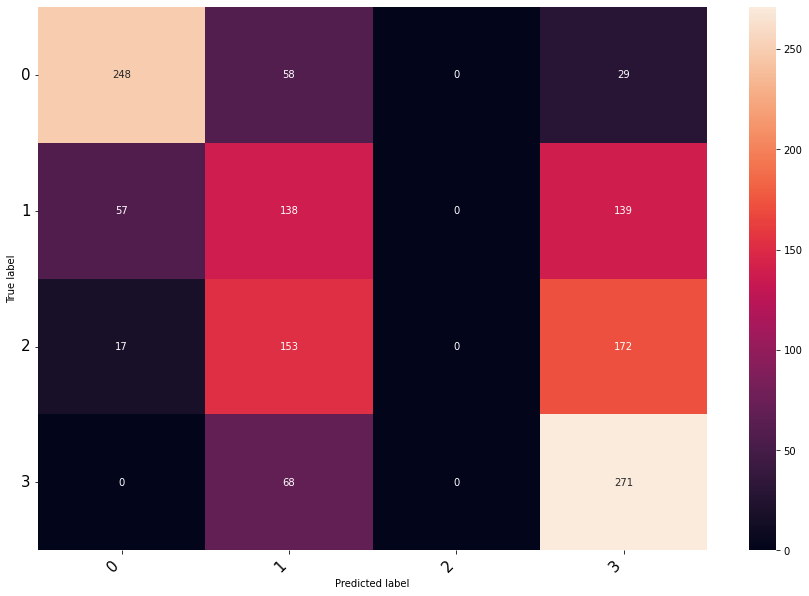

In [62]:
cm.visualize()

In [63]:
cm.class_accuracy

tensor([0.7403, 0.4132, 0.0000, 0.7994])

### Baseline Overall

In [28]:
print(dict_small_acc_train)
print(dict_small_acc_val)
print(dict_small_acc_test)

{'logistic_regression': 0.46, 'random_forest': 1.0, 'knn_classifier': 0.6}
{'random_forest': 0.47185185185185186}
{'logistic_regression': 0.4562962962962963, 'random_forest': 0.47185185185185186, 'knn_classifier': 0.38296296296296295}


In [29]:
print(dict_small_mcc_train)
print(dict_small_mcc_val)
print(dict_small_mcc_test)

{'logistic_regression': 0.2892639292086052, 'random_forest': 1.0, 'knn_classifier': 0.46813975642721894}
{'random_forest': 0.2968941246653879}
{'logistic_regression': 0.2821549906874376, 'random_forest': 0.2968941246653879, 'knn_classifier': 0.17959992838237115}


In [30]:
print(dict_small_rmse_train)
print(dict_small_rmse_val)
print(dict_small_rmse_test)

{'logistic_regression': 1.0424330514074593, 'random_forest': 0.0, 'knn_classifier': 0.983192080250175}
{'random_forest': 1.0413666234542207}
{'logistic_regression': 1.023067283548187, 'random_forest': 1.0413666234542207, 'knn_classifier': 1.259041375485804}


### GCN

In [31]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     # h_features=[[5, 10], [10, 15], [5], [10], [15], [10,15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0, 0.2, 0.4],
#     use_edge_weight=[True, False],
#     drop_edges=[0,0.2,0.4],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [32]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

#### Results

In [33]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 2224/2224 [02:09<00:00, 17.22it/s]


In [34]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.2,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.9354964,
 'train_acc': 0.476190447807312,
 'val_acc': 0.577777624130249,
 'epoch': 11,
 'model_class': 'gcn',
 'path_name': '0.58_4_[15_15_15]_4_ReLU()_none_gn_0.0_0.1_adamw_max_val_mcc_0.2_True_True_0',
 'train_mcc': 0.3025590996338239,
 'val_mcc': 0.42857142857142855,
 'test_mcc': 0.3781477382882374,
 'train_rmse': 1.082325538564332,
 'val_rmse': 0.8299933065325822,
 'test_rmse': 0.9801738318995977,
 'test_acc': 0.5325925946235657}

In [35]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 1.9501355,
 'train_acc': 0.476190447807312,
 'val_acc': 0.6444442868232727,
 'epoch': 15,
 'model_class': 'gcn',
 'path_name': '0.64_4_[10_15_20]_4_ReLU()_none_bn_0.2_0.1_adamw_max_val_mcc_0.0_True_True_0.2',
 'train_mcc': 0.3493031290351673,
 'val_mcc': 0.5254015017794055,
 'test_mcc': 0.3669867448994967,
 'train_rmse': 1.023532631438318,
 'val_rmse': 0.9428090415820634,
 'test_rmse': 0.9641730288851839,
 'test_acc': 0.512592613697052}

In [36]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.3018048,
 'train_acc': 0.5333333015441895,
 'val_acc': 0.5111109614372253,
 'epoch': 11,
 'model_class': 'gcn',
 'path_name': '0.51_4_[5_10_15_20]_4_ReLU()_none_None_0.0_0.1_adamw_max_val_mcc_0.0_True_True_0',
 'train_mcc': 0.3745988636011434,
 'val_mcc': 0.4034043894617714,
 'test_mcc': 0.40779130713159867,
 'train_rmse': 1.004750620564033,
 'val_rmse': 0.8299933065325822,
 'test_rmse': 0.9424161226062233,
 'test_acc': 0.5229629874229431}

In [37]:
pretty([all[k]['dict'] for k in sort_idx])

### GraphSAGE

In [38]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    # aggregator_type = ['mean', 'lstm'],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [10,15,10]], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [39]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

#### Results

In [40]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 5721/5721 [26:53<00:00,  3.55it/s] 


In [41]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [30],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.60041225,
 'train_acc': 0.8476189970970154,
 'val_acc': 0.7111109495162964,
 'epoch': 64,
 'model_class': 'sage',
 'path_name': '0.71_4_[30]_4_lstm_none_gn_ReLU()_0.2_0.01_adamw_max_val_mcc_0.0_True_10_True_0',
 'train_mcc': 0.7950006663847297,
 'val_mcc': 0.6087277461139105,
 'test_mcc': 0.6033871231839141,
 'train_rmse': 0.4879500364742666,
 'val_rmse': 0.6497862896539309,
 'test_rmse': 0.6429100507328637,
 'test_acc': 0.7014814615249634}

In [42]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.7704083,
 'train_acc': 0.8190475702285767,
 'val_acc': 0.7555553913116455,
 'epoch': 49,
 'model_class': 'sage',
 'path_name': '0.76_4_[25]_4_lstm_none_bn_ReLU()_0.2_0.01_adamw_max_val_mcc_0.0_True_10_True_0',
 'train_mcc': 0.7598533260827027,
 'val_mcc': 0.675085164488953,
 'test_mcc': 0.5841193098159074,
 'train_rmse': 0.6546536707079771,
 'val_rmse': 0.6146362971528592,
 'test_rmse': 0.679324283005901,
 'test_acc': 0.6874074339866638}

In [43]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.60041225,
 'train_acc': 0.8476189970970154,
 'val_acc': 0.7111109495162964,
 'epoch': 64,
 'model_class': 'sage',
 'path_name': '0.71_4_[30]_4_lstm_none_gn_ReLU()_0.2_0.01_adamw_max_val_mcc_0.0_True_10_True_0',
 'train_mcc': 0.7950006663847297,
 'val_mcc': 0.6087277461139105,
 'test_mcc': 0.6033871231839141,
 'train_rmse': 0.4879500364742666,
 'val_rmse': 0.6497862896539309,
 'test_rmse': 0.6429100507328637,
 'test_acc': 0.7014814615249634}

In [44]:
pretty([all[k]['dict'] for k in sort_idx])

#### cm

In [45]:
cm = all[sort_idx[0]]['test_cm'][0]

In [46]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

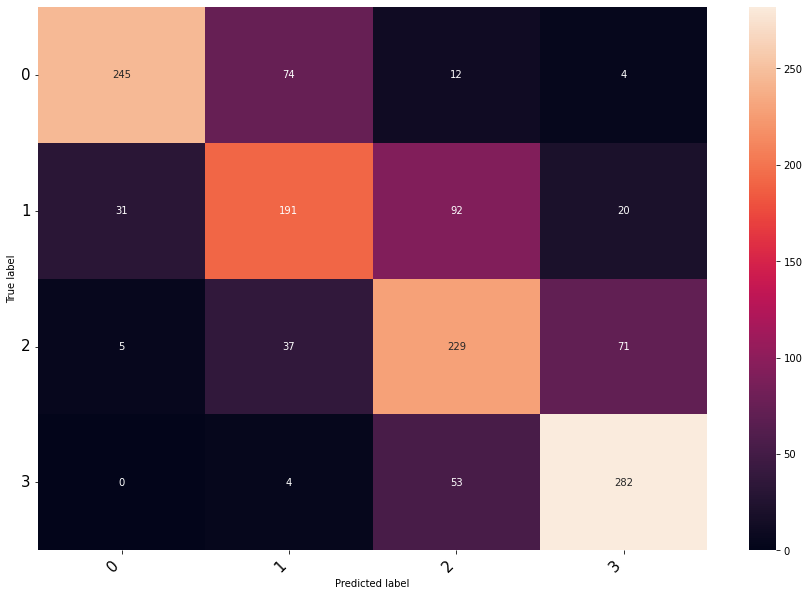

In [47]:
cm.visualize()

In [48]:
cm.class_accuracy

tensor([0.7313, 0.5719, 0.6696, 0.8319])

### GAT

In [49]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True, False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [50]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

#### Results

In [51]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 18753/18753 [14:50<00:00, 21.06it/s]


In [52]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [25],
 'out_features': 4,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.2,
 'train_use_edge_weight': False,
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.2738979,
 'train_acc': 0.6476190090179443,
 'val_acc': 0.3999998867511749,
 'epoch': 70,
 'model_class': 'gat',
 'path_name': '0.40_4_[25]_4_[4_4]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_0.2_False_10_True_0_70',
 'train_mcc': 0.5317986867169685,
 'val_mcc': 0.2354345412145177,
 'test_mcc': 0.341127563445722,
 'train_rmse': 0.8890872794479687,
 'val_rmse': 1.1055415967851334,
 'test_rmse': 1.0869597423462756,
 'test_acc': 0.49037036299705505}

In [53]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 4,
 'num_heads': [2, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.2,
 'train_use_edge_weight': True,
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.4756513,
 'train_acc': 0.5999999642372131,
 'val_acc': 0.5333331823348999,
 'epoch': 30,
 'model_class': 'gat',
 'path_name': '0.53_4_[25]_4_[2_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_0.2_True_10_True_0_30',
 'train_mcc': 0.46607446031365996,
 'val_mcc': 0.423740240389697,
 'test_mcc': 0.23787884571012657,
 'train_rmse': 0.9710083124552245,
 'val_rmse': 1.021980647783726,
 'test_rmse': 1.2733740540318392,
 'test_acc': 0.41777777671813965}

In [54]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 4,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.2,
 'train_use_edge_weight': False,
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.2738979,
 'train_acc': 0.6476190090179443,
 'val_acc': 0.3999998867511749,
 'epoch': 70,
 'model_class': 'gat',
 'path_name': '0.40_4_[25]_4_[4_4]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_0.2_False_10_True_0_70',
 'train_mcc': 0.5317986867169685,
 'val_mcc': 0.2354345412145177,
 'test_mcc': 0.341127563445722,
 'train_rmse': 0.8890872794479687,
 'val_rmse': 1.1055415967851334,
 'test_rmse': 1.0869597423462756,
 'test_acc': 0.49037036299705505}

In [55]:
pretty([all[k]['dict'] for k in sort_idx])